# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn.functional as F 

from tqdm.notebook import tqdm
import utils

# Load MNIST Handwritten Dataset

In [2]:
from torchvision import datasets 
from torchvision import transforms as T

In [3]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p = 0.5), # 50% images flip horizantally
    T.RandomVerticalFlip(p = 0.5), # 50% images flip horizantally
    T.Resize((255,255)),
    T.ToTensor(), # image to tensor (height, weight, channel) -> (channel, height, height)
   
    T.Normalize(mean=0.5, std = 0.5) # normalize
    
])

valid_augs= T.Compose([
    T.ToTensor(),
    T.Resize((255,255)),
    T.Normalize(mean = 0.5, std= 0.5)
    
])

In [4]:
trainset = datasets.ImageFolder(root="./cat_or_dog/training_set/training_set", transform = train_augs)

testset =datasets.ImageFolder(root="./cat_or_dog/test_set/test_set",transform = valid_augs)

In [5]:
trainset, validset = torch.utils.data.random_split(trainset,[7000,1005])

In [6]:
trainset.dataset.classes

['cats', 'dogs']

In [7]:
print(f"Size of trainset : {len(trainset)}")
print(f"Size of testset : {len(testset)}")
print(f"Size of validset : {len(validset)}")


Size of trainset : 7000
Size of testset : 2023
Size of validset : 1005


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of image : torch.Size([3, 255, 255])
For visualization we need (h x w x c) so using permute shape will be : torch.Size([255, 255, 3])


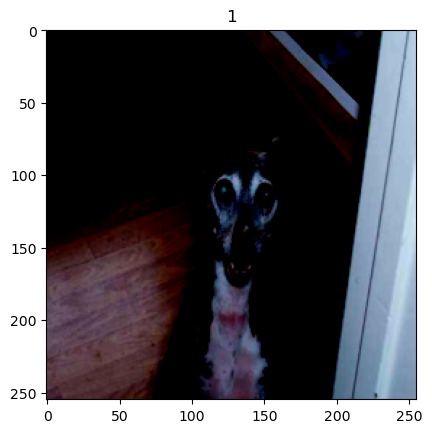

In [8]:
idx = 4
import torchvision.transforms as transforms

image, label = trainset[idx]

to_gray = transforms.Grayscale()

print(f'shape of image : {image.shape}')
print(f'For visualization we need (h x w x c) so using permute shape will be : {image.permute(1, 2, 0).shape}')#image permute cahnce location paramaets for examle in  our case channer is 0 we permute and we write channel to 2 and so on

plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
plt.title(label);

# Load Dataset into batches

In [9]:
from torch.utils.data import DataLoader

In [10]:
bs = 64

trainloader=DataLoader(trainset, batch_size=bs, shuffle=True)
validloader=DataLoader(validset, batch_size=bs)
testloader=DataLoader(testset, batch_size=bs)

In [11]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')
print(f'Total no. of batches in testloader : {len(testloader)}')

Total no. of batches in trainloader : 110
Total no. of batches in validloader : 16
Total no. of batches in testloader : 32


In [12]:
print(trainloader)

In [13]:
for images, labels in trainloader:
    to_gray = transforms.Grayscale()
    
    images = to_gray(images)

# Apply the transformation to the image
    print(f'One images batch shape: {images.shape}')
    print(f'One labels batch shape: {labels.shape}')
    break

One images batch shape: torch.Size([64, 1, 255, 255])
One labels batch shape: torch.Size([64])



# Load Model 

In [14]:
from models import DigitModel

model = DigitModel()
model.to('cpu')

DigitModel(
  (cnn_block): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(256, 64, kernel_size=(3, 3), stride=(4, 4), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, ou

# Create Train and Eval Function

In [15]:
def train_fn(model, dataloader, criterion, optimizer):
    to_gray = transforms.Grayscale()
    #resize_transform = transforms.Resize((28, 28))
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    
    for images, labels in tqdm(dataloader):
        images = to_gray(images)
        #images = resize_transform(images)
        images= images.to('cpu')
        labels = labels.to('cpu')
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += utils.multiclass_accuracy(logits, labels)
    
    return total_loss/len(dataloader), total_acc/len(dataloader)

In [16]:
def eval_fn(model, dataloader, criterion):
    to_gray = transforms.Grayscale()
    #resize_transform = transforms.Resize((28, 28))
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = to_gray(images)
            #images = resize_transform(images)

            images= images.to('cpu')
            labels = labels.to('cpu')


            logits = model(images)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            total_acc += utils.multiclass_accuracy(logits, labels)

        return total_loss/len(dataloader), total_acc/len(dataloader)

# Training Loop 

In [17]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [18]:
best_valid_loss = np.Inf

for i in range(100):
    train_loss, train_acc = train_fn(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = eval_fn(model, trainloader, criterion)
    
    print(f'Epoch {i+1} Train Loss : {train_loss} Train Acc : {train_acc}')
    print(f'Epoch {i+1} Valid Loss : {valid_loss} Valid Acc : {valid_acc}')
    
    if valid_loss<best_valid_loss:
        torch.save(model.state_dict(), 'best_weights1.pt')
        
    

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1 Train Loss : 0.6954003778370944 Train Acc : 0.5382102131843567
Epoch 1 Valid Loss : 0.7389465993100947 Valid Acc : 0.5015624761581421


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 2 Train Loss : 0.6690980943766507 Train Acc : 0.5940340757369995
Epoch 2 Valid Loss : 0.6484895744106987 Valid Acc : 0.6254734992980957


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 3 Train Loss : 0.6512614022601735 Train Acc : 0.6104639768600464
Epoch 3 Valid Loss : 0.629856244542382 Valid Acc : 0.6317235231399536


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 4 Train Loss : 0.6338737541979009 Train Acc : 0.6464962363243103
Epoch 4 Valid Loss : 0.5970547648993405 Valid Acc : 0.6738162636756897


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 5 Train Loss : 0.6264806319366801 Train Acc : 0.6489583253860474
Epoch 5 Valid Loss : 0.6172244998541745 Valid Acc : 0.6494318246841431


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 6 Train Loss : 0.6078221410512924 Train Acc : 0.6669980883598328
Epoch 6 Valid Loss : 0.6008005957711827 Valid Acc : 0.6663352251052856


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 7 Train Loss : 0.5965144775130532 Train Acc : 0.6803503632545471
Epoch 7 Valid Loss : 0.628695445169102 Valid Acc : 0.6122159361839294


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 8 Train Loss : 0.5930566776882519 Train Acc : 0.6794034242630005
Epoch 8 Valid Loss : 0.5468973089348186 Valid Acc : 0.7214015126228333


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 9 Train Loss : 0.5761098384857177 Train Acc : 0.6959753632545471
Epoch 9 Valid Loss : 0.5530736855485222 Valid Acc : 0.7144412398338318


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 10 Train Loss : 0.5662974937395616 Train Acc : 0.7106534242630005
Epoch 10 Valid Loss : 0.5333322714675557 Valid Acc : 0.7262784242630005


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 11 Train Loss : 0.5707030125639655 Train Acc : 0.7134469747543335
Epoch 11 Valid Loss : 0.5300865157084031 Valid Acc : 0.7433712482452393


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 12 Train Loss : 0.5496764356439764 Train Acc : 0.7220170497894287
Epoch 12 Valid Loss : 0.5332762506875125 Valid Acc : 0.7402462363243103


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 13 Train Loss : 0.5448428758166053 Train Acc : 0.7265151143074036
Epoch 13 Valid Loss : 0.5313430959528143 Valid Acc : 0.7439393997192383


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 14 Train Loss : 0.5398761364546689 Train Acc : 0.7202651500701904
Epoch 14 Valid Loss : 0.5325736560604789 Valid Acc : 0.7419034242630005


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 15 Train Loss : 0.52993857616728 Train Acc : 0.7342329621315002
Epoch 15 Valid Loss : 0.5403043226762252 Valid Acc : 0.7177556753158569


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 16 Train Loss : 0.5232160966504704 Train Acc : 0.7401514649391174
Epoch 16 Valid Loss : 0.5219535291194916 Valid Acc : 0.7315340638160706


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 17 Train Loss : 0.5138592264868996 Train Acc : 0.7464962601661682
Epoch 17 Valid Loss : 0.5006041637875817 Valid Acc : 0.7515151500701904


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 18 Train Loss : 0.5034795511852611 Train Acc : 0.7577651143074036
Epoch 18 Valid Loss : 0.4750312493606047 Valid Acc : 0.7661458253860474


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 19 Train Loss : 0.4922163172201677 Train Acc : 0.7686553001403809
Epoch 19 Valid Loss : 0.4617901089516553 Valid Acc : 0.7811079621315002


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 20 Train Loss : 0.48965843374078927 Train Acc : 0.7683238387107849
Epoch 20 Valid Loss : 0.45978200056336144 Valid Acc : 0.7729166746139526


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 21 Train Loss : 0.481154037063772 Train Acc : 0.7772253751754761
Epoch 21 Valid Loss : 0.43760685460133986 Valid Acc : 0.8003787398338318


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 22 Train Loss : 0.4719823108478026 Train Acc : 0.7789772748947144
Epoch 22 Valid Loss : 0.466568001833829 Valid Acc : 0.7721590995788574


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 23 Train Loss : 0.46149214722893456 Train Acc : 0.7816761136054993
Epoch 23 Valid Loss : 0.47308994341980326 Valid Acc : 0.7583333253860474


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 24 Train Loss : 0.4433844720775431 Train Acc : 0.7956439852714539
Epoch 24 Valid Loss : 0.40364223258061843 Valid Acc : 0.8163352012634277


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 25 Train Loss : 0.44177038832144305 Train Acc : 0.8010889887809753
Epoch 25 Valid Loss : 0.4360250968824733 Valid Acc : 0.7930871248245239


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 26 Train Loss : 0.4340983298691836 Train Acc : 0.802793562412262
Epoch 26 Valid Loss : 0.39407670904289593 Valid Acc : 0.8355113863945007


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 27 Train Loss : 0.41928816546093334 Train Acc : 0.8128787875175476
Epoch 27 Valid Loss : 0.3878900141878562 Valid Acc : 0.830492377281189


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 28 Train Loss : 0.3958226000720804 Train Acc : 0.8133049011230469
Epoch 28 Valid Loss : 0.4039966892112385 Valid Acc : 0.8286458253860474


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 29 Train Loss : 0.39660068655555897 Train Acc : 0.822679877281189
Epoch 29 Valid Loss : 0.40363239754330027 Valid Acc : 0.8016571998596191


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 30 Train Loss : 0.37961071851578626 Train Acc : 0.8296401500701904
Epoch 30 Valid Loss : 0.3481941836801442 Valid Acc : 0.846543550491333


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 31 Train Loss : 0.3807840737429532 Train Acc : 0.8321496248245239
Epoch 31 Valid Loss : 0.36773798262531104 Valid Acc : 0.8397727012634277


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 32 Train Loss : 0.38353017202832485 Train Acc : 0.8316287398338318
Epoch 32 Valid Loss : 0.31589378971945153 Valid Acc : 0.8758996725082397


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 33 Train Loss : 0.3477551839568398 Train Acc : 0.8531723618507385
Epoch 33 Valid Loss : 0.3161985845728354 Valid Acc : 0.8700757622718811


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 34 Train Loss : 0.3422706887125969 Train Acc : 0.8501893877983093
Epoch 34 Valid Loss : 0.31195342147892174 Valid Acc : 0.8667613863945007


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 35 Train Loss : 0.33085601153698835 Train Acc : 0.8581912517547607
Epoch 35 Valid Loss : 0.32500742430036716 Valid Acc : 0.8772727251052856


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 36 Train Loss : 0.33845385204661976 Train Acc : 0.8550662398338318
Epoch 36 Valid Loss : 0.3007741019129753 Valid Acc : 0.8837121725082397


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 37 Train Loss : 0.3031216750090772 Train Acc : 0.8723011612892151
Epoch 37 Valid Loss : 0.31573402664878153 Valid Acc : 0.8618844747543335


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 38 Train Loss : 0.308813275532289 Train Acc : 0.8683238625526428
Epoch 38 Valid Loss : 0.35946799665689466 Valid Acc : 0.845075786113739


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 39 Train Loss : 0.29466228200630706 Train Acc : 0.879450798034668
Epoch 39 Valid Loss : 0.2886954818259586 Valid Acc : 0.879450798034668


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 40 Train Loss : 0.28748091635378925 Train Acc : 0.8837121725082397
Epoch 40 Valid Loss : 0.30484968572855 Valid Acc : 0.859375


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 41 Train Loss : 0.2844291784546592 Train Acc : 0.8821496367454529
Epoch 41 Valid Loss : 0.3383346531878818 Valid Acc : 0.8514204621315002


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 42 Train Loss : 0.2685254687612707 Train Acc : 0.8880681991577148
Epoch 42 Valid Loss : 0.37297659651799636 Valid Acc : 0.8219223618507385


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 43 Train Loss : 0.2756042313846675 Train Acc : 0.8863636255264282
Epoch 43 Valid Loss : 0.3259065293452956 Valid Acc : 0.8662405610084534


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 44 Train Loss : 0.25659464170986956 Train Acc : 0.8936079740524292
Epoch 44 Valid Loss : 0.2712567356499759 Valid Acc : 0.8928977251052856


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 45 Train Loss : 0.24538279243490912 Train Acc : 0.8989109992980957
Epoch 45 Valid Loss : 0.24134557396173478 Valid Acc : 0.9077651500701904


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 46 Train Loss : 0.24158614508130333 Train Acc : 0.8975378274917603
Epoch 46 Valid Loss : 0.2566805296323516 Valid Acc : 0.8830965757369995


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 47 Train Loss : 0.2240686147050424 Train Acc : 0.9074337482452393
Epoch 47 Valid Loss : 0.20736292153596877 Valid Acc : 0.9307292103767395


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 48 Train Loss : 0.21517453735524958 Train Acc : 0.9161458015441895
Epoch 48 Valid Loss : 0.20184707363898105 Valid Acc : 0.9238636493682861


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 49 Train Loss : 0.21298977841030467 Train Acc : 0.9173769354820251
Epoch 49 Valid Loss : 0.320472381467169 Valid Acc : 0.8533617258071899


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 50 Train Loss : 0.2243068960579959 Train Acc : 0.9074810147285461
Epoch 50 Valid Loss : 0.199003280563788 Valid Acc : 0.924242377281189


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 51 Train Loss : 0.21131055334752255 Train Acc : 0.9157196879386902
Epoch 51 Valid Loss : 0.18892355412244796 Valid Acc : 0.9278882741928101


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 52 Train Loss : 0.1879182769832286 Train Acc : 0.926325798034668
Epoch 52 Valid Loss : 0.18022267093712632 Valid Acc : 0.9221590757369995


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 53 Train Loss : 0.1939812681214376 Train Acc : 0.9249053001403809
Epoch 53 Valid Loss : 0.1714229373092001 Valid Acc : 0.934706449508667


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 54 Train Loss : 0.2004000144248659 Train Acc : 0.923200786113739
Epoch 54 Valid Loss : 0.1601593405008316 Valid Acc : 0.9372633099555969


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 55 Train Loss : 0.1896345915780826 Train Acc : 0.9270359873771667
Epoch 55 Valid Loss : 0.1774510204114697 Valid Acc : 0.9359848499298096


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 56 Train Loss : 0.18203164308585904 Train Acc : 0.9306818246841431
Epoch 56 Valid Loss : 0.1727827601134777 Valid Acc : 0.9270359873771667


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 57 Train Loss : 0.17235717888582835 Train Acc : 0.9331912398338318
Epoch 57 Valid Loss : 0.16274754625152457 Valid Acc : 0.9402462244033813


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 58 Train Loss : 0.15881286825646054 Train Acc : 0.9373579621315002
Epoch 58 Valid Loss : 0.1289847803386775 Valid Acc : 0.9567235112190247


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 59 Train Loss : 0.16465611769394442 Train Acc : 0.9349431991577148
Epoch 59 Valid Loss : 0.18799647031859917 Valid Acc : 0.9336647987365723


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 60 Train Loss : 0.1622720967978239 Train Acc : 0.9380682110786438
Epoch 60 Valid Loss : 0.1286159721287814 Valid Acc : 0.9569602012634277


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 61 Train Loss : 0.15379438803277232 Train Acc : 0.9421401023864746
Epoch 61 Valid Loss : 0.14945835064757954 Valid Acc : 0.9463068246841431


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 62 Train Loss : 0.14261268441650002 Train Acc : 0.9431344270706177
Epoch 62 Valid Loss : 0.12563703199001877 Valid Acc : 0.9485795497894287


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 63 Train Loss : 0.13927510976791382 Train Acc : 0.9464962482452393
Epoch 63 Valid Loss : 0.17563554333014922 Valid Acc : 0.9209753274917603


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 64 Train Loss : 0.1363971971314062 Train Acc : 0.9474905729293823
Epoch 64 Valid Loss : 0.1140018892051144 Valid Acc : 0.9586647748947144


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 65 Train Loss : 0.13431144031611356 Train Acc : 0.9487689733505249
Epoch 65 Valid Loss : 0.11171618588268757 Valid Acc : 0.9595643877983093


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 66 Train Loss : 0.11956922814927318 Train Acc : 0.950331449508667
Epoch 66 Valid Loss : 0.11505058590661396 Valid Acc : 0.9621685147285461


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 67 Train Loss : 0.13806615322828292 Train Acc : 0.9478693008422852
Epoch 67 Valid Loss : 0.1697049144655466 Valid Acc : 0.9331439733505249


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 68 Train Loss : 0.12329535279422998 Train Acc : 0.9546401500701904
Epoch 68 Valid Loss : 0.11348874040625312 Valid Acc : 0.9551610350608826


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 69 Train Loss : 0.13278366169807584 Train Acc : 0.9477746486663818
Epoch 69 Valid Loss : 0.10125364417379552 Valid Acc : 0.9688920378684998


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 70 Train Loss : 0.12558984903788026 Train Acc : 0.9511837363243103
Epoch 70 Valid Loss : 0.08776746588674458 Valid Acc : 0.9704545736312866


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 71 Train Loss : 0.11405563362958757 Train Acc : 0.9582386612892151
Epoch 71 Valid Loss : 0.1286193534393202 Valid Acc : 0.9549716114997864


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 72 Train Loss : 0.11756407742134549 Train Acc : 0.9564394354820251
Epoch 72 Valid Loss : 0.07896306089718233 Valid Acc : 0.9742423892021179


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 73 Train Loss : 0.1097703561864116 Train Acc : 0.9604640007019043
Epoch 73 Valid Loss : 0.10275147188116204 Valid Acc : 0.9635416865348816


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 74 Train Loss : 0.12161827166988091 Train Acc : 0.953456461429596
Epoch 74 Valid Loss : 0.08888395814733072 Valid Acc : 0.9727272987365723


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 75 Train Loss : 0.12646680567413568 Train Acc : 0.9571969509124756
Epoch 75 Valid Loss : 0.1507290099154819 Valid Acc : 0.9432291984558105


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 76 Train Loss : 0.11409461733631113 Train Acc : 0.9606534242630005
Epoch 76 Valid Loss : 0.0916133449497548 Valid Acc : 0.9725852012634277


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 77 Train Loss : 0.10684664918279106 Train Acc : 0.9605113863945007
Epoch 77 Valid Loss : 0.15834960944273255 Valid Acc : 0.9290719628334045


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 78 Train Loss : 0.12096427023749459 Train Acc : 0.957575798034668
Epoch 78 Valid Loss : 0.13353325900706378 Valid Acc : 0.9500473737716675


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 79 Train Loss : 0.1007264903831211 Train Acc : 0.9618371725082397
Epoch 79 Valid Loss : 0.09765758998692035 Valid Acc : 0.9604166746139526


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 80 Train Loss : 0.11995306609367783 Train Acc : 0.9573863744735718
Epoch 80 Valid Loss : 0.11271638025275686 Valid Acc : 0.9518939852714539


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 81 Train Loss : 0.1054995747283101 Train Acc : 0.9592329263687134
Epoch 81 Valid Loss : 0.09410427957773208 Valid Acc : 0.9607954621315002


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 82 Train Loss : 0.1024801865728064 Train Acc : 0.9626420736312866
Epoch 82 Valid Loss : 0.06798324595120821 Valid Acc : 0.9791666865348816


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 83 Train Loss : 0.0862600296312435 Train Acc : 0.9670928120613098
Epoch 83 Valid Loss : 0.058708928593180394 Valid Acc : 0.9811079502105713


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 84 Train Loss : 0.09885558419945566 Train Acc : 0.9638257622718811
Epoch 84 Valid Loss : 0.06996202651749958 Valid Acc : 0.9801136255264282


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 85 Train Loss : 0.09999558612365614 Train Acc : 0.9648674130439758
Epoch 85 Valid Loss : 0.09601802649823102 Valid Acc : 0.9625473618507385


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 86 Train Loss : 0.10592736214060675 Train Acc : 0.9619792103767395
Epoch 86 Valid Loss : 0.09988483231176029 Valid Acc : 0.9710227251052856


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 87 Train Loss : 0.10183652390471913 Train Acc : 0.9634943008422852
Epoch 87 Valid Loss : 0.11532889414917338 Valid Acc : 0.9583806991577148


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 88 Train Loss : 0.08848401074382392 Train Acc : 0.9672821760177612
Epoch 88 Valid Loss : 0.058974997572262176 Valid Acc : 0.9828125238418579


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 89 Train Loss : 0.07616122537715868 Train Acc : 0.9744791984558105
Epoch 89 Valid Loss : 0.06023802522739226 Valid Acc : 0.9769886136054993


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 90 Train Loss : 0.1007399169982157 Train Acc : 0.9630208015441895
Epoch 90 Valid Loss : 0.07718863902105526 Valid Acc : 0.976893961429596


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 91 Train Loss : 0.10048406356945634 Train Acc : 0.9636837244033813
Epoch 91 Valid Loss : 0.08903002283451232 Valid Acc : 0.968418538570404


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 92 Train Loss : 0.08654999158091166 Train Acc : 0.9675189852714539
Epoch 92 Valid Loss : 0.0646807389672507 Valid Acc : 0.978456437587738


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 93 Train Loss : 0.07970854872837663 Train Acc : 0.9703124761581421
Epoch 93 Valid Loss : 0.052621914467520334 Valid Acc : 0.9830018877983093


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 94 Train Loss : 0.07803783750965852 Train Acc : 0.9694602489471436
Epoch 94 Valid Loss : 0.044730924535542727 Valid Acc : 0.9826704263687134


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 95 Train Loss : 0.07765940141186796 Train Acc : 0.9730587601661682
Epoch 95 Valid Loss : 0.0697558868676424 Valid Acc : 0.9736742377281189


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 96 Train Loss : 0.07055481042374265 Train Acc : 0.976231038570404
Epoch 96 Valid Loss : 0.04213579666631466 Valid Acc : 0.9875473976135254


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 97 Train Loss : 0.06431886033917016 Train Acc : 0.9752840995788574
Epoch 97 Valid Loss : 0.05892004079016095 Valid Acc : 0.979687511920929


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 98 Train Loss : 0.08123752015050162 Train Acc : 0.9687973856925964
Epoch 98 Valid Loss : 0.06049420984292572 Valid Acc : 0.9821496605873108


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 99 Train Loss : 0.0733431775927205 Train Acc : 0.9745738506317139
Epoch 99 Valid Loss : 0.06289886466481469 Valid Acc : 0.9829545617103577


  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Epoch 100 Train Loss : 0.07512539464726367 Train Acc : 0.9737215638160706
Epoch 100 Valid Loss : 0.05102032375606624 Valid Acc : 0.9815340638160706


# Inference

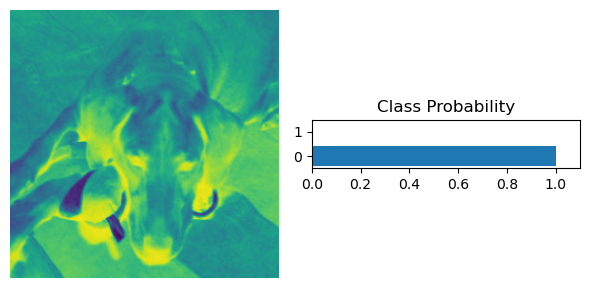

In [35]:
image, label = testset[1206]

weights = torch.load('best_weights1.pt')
model.load_state_dict(weights)
resize_transform = transforms.Resize((255, 255))
model.eval()

image = to_gray(image)
#image = resize_transform(image)
image=255-image

with torch.no_grad():
    logits = model(image.unsqueeze(0)) #(c,h,w)->(1,c,h,w) in here we add 1 addininal column for batch size
    ps= torch.nn.Softmax(dim=1)(logits)[0]
    utils.view_classify(image,ps)

[[[ 39  69  34]
  [ 38  69  32]
  [ 37  68  31]
  ...
  [ 39  90  40]
  [ 41  91  43]
  [ 43  93  45]]

 [[ 35  66  27]
  [ 35  66  27]
  [ 35  66  27]
  ...
  [ 41  92  42]
  [ 41  92  42]
  [ 42  93  43]]

 [[ 36  67  28]
  [ 37  68  29]
  [ 37  68  29]
  ...
  [ 42  93  43]
  [ 42  93  43]
  [ 42  94  41]]

 ...

 [[ 14  53 122]
  [  9  48 116]
  [ 12  50 115]
  ...
  [ 50 138  72]
  [ 47 138  69]
  [ 47 139  68]]

 [[ 37  75 139]
  [ 37  75 139]
  [ 45  82 142]
  ...
  [ 48 136  70]
  [ 48 136  70]
  [ 48 137  68]]

 [[ 62 100 158]
  [ 66 103 159]
  [ 73 110 166]
  ...
  [ 48 134  70]
  [ 48 135  69]
  [ 48 135  69]]]
tensor([0.3003, 0.6997])


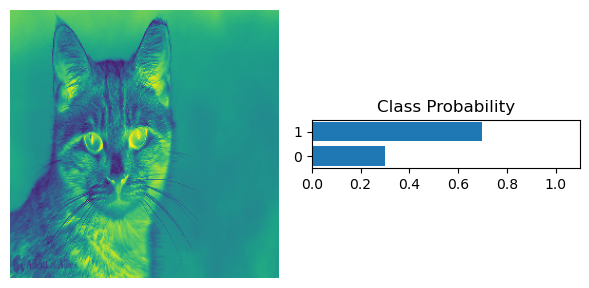

In [33]:
import cv2
from PIL import Image

model=DigitModel()
model.load_state_dict(torch.load('best_weights1.pt'))


image_path = 'test_photo/cat2.jpg' 
test_img = cv2.imread(image_path)
print(test_img)
#img= test_img.astype(np.uint8)
test_img = 255 - test_img

img= cv2.resize(test_img.astype('uint8'),(255,255))
img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #(28,28)->(28,28,1)
img= img[:,:,np.newaxis]/255.0

with torch.no_grad():
    img=torch.Tensor(img).permute(2,0,1)
    logits = model(img.unsqueeze(0)) 
    ps= torch.nn.Softmax(dim=1)(logits)[0]
   
    print(ps)
    utils.view_classify(img,ps)
